## Install library

In [ ]:
# set up our code
!pip install git+https://github.com/xinyu1205/recognize-anything.git
%rm -rf recognize-anything
!git clone https://github.com/xinyu1205/recognize-anything.git
%cd /kaggle/working/recognize-anything
!pip install -r requirements.txt
!pip install -e .


%cd /kaggle/working/
# set up Grounded-SAM
# you will need to clone Grounded-SAM repo
%rm -rf Grounded-Segment-Anything
!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git

Cloning into 'recognize-anything'...
remote: Enumerating objects: 737, done.
remote: Counting objects: 100% (447/447), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 737 (delta 310), reused 285 (delta 223), pack-reused 290 (from 1)
Receiving objects: 100% (737/737), 27.14 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (397/397), done.
/kaggle/working/recognize-anything
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-rcu26sjw/clip_c34db2f827b04d53bc8279ea81e08357
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-rcu26sjw/clip_c34db2f827b04d53bc8279ea81e08357
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Obtaining file:///kaggle/working/recognize-anything
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-srg3yp_z/clip_8a93cc0d939b49568d217ccf033

## Fix error _C

In [ ]:
with open("/kaggle/working/Grounded-Segment-Anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py","w") as f:
    f.write('''

import math
import warnings
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from torch.nn.init import constant_, xavier_uniform_


# helpers
def _is_power_of_2(n):
    if (not isinstance(n, int)) or (n < 0):
        raise ValueError("invalid input for _is_power_of_2: {} (type: {})".format(n, type(n)))
    return (n & (n - 1) == 0) and n != 0


def multi_scale_deformable_attn_pytorch(
    value: torch.Tensor,
    value_spatial_shapes: torch.Tensor,
    sampling_locations: torch.Tensor,
    attention_weights: torch.Tensor,
) -> torch.Tensor:

    bs, _, num_heads, embed_dims = value.shape
    _, num_queries, num_heads, num_levels, num_points, _ = sampling_locations.shape
    value_list = value.split([H_ * W_ for H_, W_ in value_spatial_shapes], dim=1)
    sampling_grids = 2 * sampling_locations - 1
    sampling_value_list = []
    for level, (H_, W_) in enumerate(value_spatial_shapes):
        # bs, H_*W_, num_heads, embed_dims ->
        # bs, H_*W_, num_heads*embed_dims ->
        # bs, num_heads*embed_dims, H_*W_ ->
        # bs*num_heads, embed_dims, H_, W_
        value_l_ = (
            value_list[level].flatten(2).transpose(1, 2).reshape(bs * num_heads, embed_dims, H_, W_)
        )
        # bs, num_queries, num_heads, num_points, 2 ->
        # bs, num_heads, num_queries, num_points, 2 ->
        # bs*num_heads, num_queries, num_points, 2
        sampling_grid_l_ = sampling_grids[:, :, :, level].transpose(1, 2).flatten(0, 1)
        # bs*num_heads, embed_dims, num_queries, num_points
        sampling_value_l_ = F.grid_sample(
            value_l_, sampling_grid_l_, mode="bilinear", padding_mode="zeros", align_corners=False
        )
        sampling_value_list.append(sampling_value_l_)
    # (bs, num_queries, num_heads, num_levels, num_points) ->
    # (bs, num_heads, num_queries, num_levels, num_points) ->
    # (bs, num_heads, 1, num_queries, num_levels*num_points)
    attention_weights = attention_weights.transpose(1, 2).reshape(
        bs * num_heads, 1, num_queries, num_levels * num_points
    )
    output = (
        (torch.stack(sampling_value_list, dim=-2).flatten(-2) * attention_weights)
        .sum(-1)
        .view(bs, num_heads * embed_dims, num_queries)
    )
    return output.transpose(1, 2).contiguous()


class MultiScaleDeformableAttention(nn.Module):
    """Multi-Scale Deformable Attention Module used in Deformable-DETR

    `Deformable DETR: Deformable Transformers for End-to-End Object Detection.
    <https://arxiv.org/pdf/2010.04159.pdf>`_.

    Args:
        embed_dim (int): The embedding dimension of Attention. Default: 256.
        num_heads (int): The number of attention heads. Default: 8.
        num_levels (int): The number of feature map used in Attention. Default: 4.
        num_points (int): The number of sampling points for each query
            in each head. Default: 4.
        img2col_steps (int): The step used in image_to_column. Defualt: 64.
            dropout (float): Dropout layer used in output. Default: 0.1.
        batch_first (bool): if ``True``, then the input and output tensor will be
            provided as `(bs, n, embed_dim)`. Default: False. `(n, bs, embed_dim)`
    """

    def __init__(
        self,
        embed_dim: int = 256,
        num_heads: int = 8,
        num_levels: int = 4,
        num_points: int = 4,
        img2col_step: int = 64,
        batch_first: bool = False,
    ):
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                "embed_dim must be divisible by num_heads, but got {} and {}".format(
                    embed_dim, num_heads
                )
            )
        head_dim = embed_dim // num_heads

        self.batch_first = batch_first

        if not _is_power_of_2(head_dim):
            warnings.warn(
                """
                You'd better set d_model in MSDeformAttn to make sure that
                each dim of the attention head a power of 2, which is more efficient.
                """
            )

        self.im2col_step = img2col_step
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_levels = num_levels
        self.num_points = num_points
        self.sampling_offsets = nn.Linear(embed_dim, num_heads * num_levels * num_points * 2)
        self.attention_weights = nn.Linear(embed_dim, num_heads * num_levels * num_points)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        self.output_proj = nn.Linear(embed_dim, embed_dim)

        self.init_weights()

    def _reset_parameters(self):
        return self.init_weights()

    def init_weights(self):
        """
        Default initialization for Parameters of Module.
        """
        constant_(self.sampling_offsets.weight.data, 0.0)
        thetas = torch.arange(self.num_heads, dtype=torch.float32) * (
            2.0 * math.pi / self.num_heads
        )
        grid_init = torch.stack([thetas.cos(), thetas.sin()], -1)
        grid_init = (
            (grid_init / grid_init.abs().max(-1, keepdim=True)[0])
            .view(self.num_heads, 1, 1, 2)
            .repeat(1, self.num_levels, self.num_points, 1)
        )
        for i in range(self.num_points):
            grid_init[:, :, i, :] *= i + 1
        with torch.no_grad():
            self.sampling_offsets.bias = nn.Parameter(grid_init.view(-1))
        constant_(self.attention_weights.weight.data, 0.0)
        constant_(self.attention_weights.bias.data, 0.0)
        xavier_uniform_(self.value_proj.weight.data)
        constant_(self.value_proj.bias.data, 0.0)
        xavier_uniform_(self.output_proj.weight.data)
        constant_(self.output_proj.bias.data, 0.0)

    def freeze_sampling_offsets(self):
        print("Freeze sampling offsets")
        self.sampling_offsets.weight.requires_grad = False
        self.sampling_offsets.bias.requires_grad = False

    def freeze_attention_weights(self):
        print("Freeze attention weights")
        self.attention_weights.weight.requires_grad = False
        self.attention_weights.bias.requires_grad = False

    def forward(
        self,
        query: torch.Tensor,
        key: Optional[torch.Tensor] = None,
        value: Optional[torch.Tensor] = None,
        query_pos: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        reference_points: Optional[torch.Tensor] = None,
        spatial_shapes: Optional[torch.Tensor] = None,
        level_start_index: Optional[torch.Tensor] = None,
        **kwargs
    ) -> torch.Tensor:

        """Forward Function of MultiScaleDeformableAttention

        Args:
            query (torch.Tensor): Query embeddings with shape
                `(num_query, bs, embed_dim)`
            key (torch.Tensor): Key embeddings with shape
                `(num_key, bs, embed_dim)`
            value (torch.Tensor): Value embeddings with shape
                `(num_key, bs, embed_dim)`
            query_pos (torch.Tensor): The position embedding for `query`. Default: None.
            key_padding_mask (torch.Tensor): ByteTensor for `query`, with shape `(bs, num_key)`,
                indicating which elements within `key` to be ignored in attention.
            reference_points (torch.Tensor): The normalized reference points
                with shape `(bs, num_query, num_levels, 2)`,
                all elements is range in [0, 1], top-left (0, 0),
                bottom-right (1, 1), including padding are.
                or `(N, Length_{query}, num_levels, 4)`, add additional
                two dimensions `(h, w)` to form reference boxes.
            spatial_shapes (torch.Tensor): Spatial shape of features in different levels.
                With shape `(num_levels, 2)`, last dimension represents `(h, w)`.
            level_start_index (torch.Tensor): The start index of each level. A tensor with
                shape `(num_levels, )` which can be represented as
                `[0, h_0 * w_0, h_0 * w_0 + h_1 * w_1, ...]`.

        Returns:
            torch.Tensor: forward results with shape `(num_query, bs, embed_dim)`
        """

        if value is None:
            value = query

        if query_pos is not None:
            query = query + query_pos

        if not self.batch_first:
            # change to (bs, num_query ,embed_dims)
            query = query.permute(1, 0, 2)
            value = value.permute(1, 0, 2)

        bs, num_query, _ = query.shape
        bs, num_value, _ = value.shape

        assert (spatial_shapes[:, 0] * spatial_shapes[:, 1]).sum() == num_value

        value = self.value_proj(value)
        if key_padding_mask is not None:
            value = value.masked_fill(key_padding_mask[..., None], float(0))
        value = value.view(bs, num_value, self.num_heads, -1)
        sampling_offsets = self.sampling_offsets(query).view(
            bs, num_query, self.num_heads, self.num_levels, self.num_points, 2
        )
        attention_weights = self.attention_weights(query).view(
            bs, num_query, self.num_heads, self.num_levels * self.num_points
        )
        attention_weights = attention_weights.softmax(-1)
        attention_weights = attention_weights.view(
            bs,
            num_query,
            self.num_heads,
            self.num_levels,
            self.num_points,
        )

        # bs, num_query, num_heads, num_levels, num_points, 2
        if reference_points.shape[-1] == 2:
            offset_normalizer = torch.stack([spatial_shapes[..., 1], spatial_shapes[..., 0]], -1)
            sampling_locations = (
                reference_points[:, :, None, :, None, :]
                + sampling_offsets / offset_normalizer[None, None, None, :, None, :]
            )
        elif reference_points.shape[-1] == 4:
            sampling_locations = (
                reference_points[:, :, None, :, None, :2]
                + sampling_offsets
                / self.num_points
                * reference_points[:, :, None, :, None, 2:]
                * 0.5
            )
        else:
            raise ValueError(
                "Last dim of reference_points must be 2 or 4, but get {} instead.".format(
                    reference_points.shape[-1]
                )
            )
    
        
        output = multi_scale_deformable_attn_pytorch(
            value, spatial_shapes, sampling_locations, attention_weights
        )

        output = self.output_proj(output)

        if not self.batch_first:
            output = output.permute(1, 0, 2)

        return output


def create_dummy_class(klass, dependency, message=""):
    """
    When a dependency of a class is not available, create a dummy class which throws ImportError
    when used.

    Args:
        klass (str): name of the class.
        dependency (str): name of the dependency.
        message: extra message to print
    Returns:
        class: a class object
    """
    err = "Cannot import '{}', therefore '{}' is not available.".format(dependency, klass)
    if message:
        err = err + " " + message

    class _DummyMetaClass(type):
        # throw error on class attribute access
        def __getattr__(_, __):  # noqa: B902
            raise ImportError(err)

    class _Dummy(object, metaclass=_DummyMetaClass):
        # throw error on constructor
        def __init__(self, *args, **kwargs):
            raise ImportError(err)

    return _Dummy


def create_dummy_func(func, dependency, message=""):
    """
    When a dependency of a function is not available, create a dummy function which throws
    ImportError when used.

    Args:
        func (str): name of the function.
        dependency (str or list[str]): name(s) of the dependency.
        message: extra message to print
    Returns:
        function: a function object
    """
    err = "Cannot import '{}', therefore '{}' is not available.".format(dependency, func)
    if message:
        err = err + " " + message

    if isinstance(dependency, (list, tuple)):
        dependency = ",".join(dependency)

    def _dummy(*args, **kwargs):
        raise ImportError(err)

    return _dummy
    ''')

In [ ]:
%cd /kaggle/working/Grounded-Segment-Anything
!pip install -r requirements.txt
%pip install ./segment_anything
%pip install ./GroundingDINO
%cd ..
%pip install opencv-python pycocotools matplotlib onnxruntime onnx ipykernel

/kaggle/working/Grounded-Segment-Anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 57.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 62.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 72.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download model

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

--2024-08-27 17:04:10--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.19, 18.238.176.115, 18.238.176.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   205MB/s    in 12s     

2024-08-27 17:04:22 (200 MB/s) - 'sam_vit_h_4b8939.pth' saved [2564550879/2564550879]

--2024-08-27 17:04:23--  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/611591640/f221

## Config

In [ ]:
# arguments.
#
# before you go, please download following 4 checkpoints:
# download RAM and Tag2Text checkpoints to ./pretrained/ from https://github.com/majinyu666/recognize-anything/tree/main#toolbox-checkpoints
# download GroundingDINO and SAM checkpoints to ./4Grounded-Segment-Anything/ from step 1 of https://github.com/IDEA-Research/Grounded-Segment-Anything#running_man-grounded-sam-detect-and-segment-everything-with-text-prompt

config_file = "/kaggle/working/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
ram_checkpoint = "/kaggle/input/pretrain/ram_swin_large_14m.pth"
grounded_checkpoint = "/kaggle/working/groundingdino_swint_ogc.pth"
sam_checkpoint = "/kaggle/working/sam_vit_h_4b8939.pth"
box_threshold = 0.25
text_threshold = 0.2
iou_threshold = 0.5
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [72]:
# model loading, inference and visualization functions
%cd /kaggle/working/recognize-anything
import os
import random

import cv2
import groundingdino.datasets.transforms as T
import numpy as np
import torch
import torchvision
import torchvision.transforms as TS
from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from PIL import Image, ImageDraw, ImageFont
from ram import inference_ram 
from ram.models import ram
from ram.models import tag2text
from segment_anything import SamPredictor, build_sam


def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(
        clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    scores = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(
            logit > text_threshold, tokenized, tokenlizer)
        pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        scores.append(logit.max().item())

    return boxes_filt, torch.Tensor(scores), pred_phrases



@torch.no_grad()
def inference(
    raw_image, tagging_model, grounding_dino_model, sam_model
):
    raw_image = raw_image.convert("RGB")

    # run tagging model
    normalize = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = TS.Compose([
        TS.Resize((384, 384)),
        TS.ToTensor(),
        normalize
    ])

    image = raw_image.resize((384, 384))
    image = transform(image).unsqueeze(0).to(device)

    res = inference_ram(image, tagging_model)
    tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')


    # run groundingDINO
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image, _ = transform(raw_image, None)  # 3, h, w

    boxes_filt, scores, pred_phrases = get_grounding_output(
        grounding_dino_model, image, tags, box_threshold, text_threshold, device=device
    )
    # run SAM
    image = np.asarray(raw_image)
    sam_model.set_image(image)
    

    size = raw_image.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    # use NMS to handle overlapped boxes
    nms_idx = torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
    boxes_filt = boxes_filt[nms_idx]
    pred_phrases = [pred_phrases[idx] for idx in nms_idx]

    return tags, boxes_filt.cpu().detach().numpy(), pred_phrases

/kaggle/working/recognize-anything


In [ ]:
# load RAM
ram_model = ram(pretrained=ram_checkpoint, image_size=384, vit='swin_l')
ram_model.eval()
ram_model = ram_model.to(device)

# load groundingDINO
grounding_dino_model = load_model(config_file, grounded_checkpoint, device=device)

# load SAM
sam_model = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
/kaggle/input/pretrain/ram_swin_large_14m.pth
--------------
load checkpoint from /kaggle/input/pretrain/ram_swin_large_14m.pth
vit: swin_l
final text_encoder_type: bert-base-uncased


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class BBoxGrid:
    def __init__(self, bboxes, labels, grid_size=7, image_width=1280, image_height=720):
        self.bboxes = bboxes
        self.labels = ["_".join(l.split('(')[0].strip().split()) for l in labels]
        self.grid_size = grid_size
        self.grid_columns = list(map(str, range(grid_size)))  # ['0', '1', '2', ..., '6']
        self.grid_rows = list('abcdefg')  # ['a', 'b', 'c', ..., 'g']
        self.grid_width = image_width / grid_size
        self.grid_height = image_height / grid_size
        self.image_width = image_width
        self.image_height = image_height

    def get_grid(self, bbox):
        '''Get grid cells that the bounding box occupies'''
        x_min, y_min, x_max, y_max = bbox
        col_start = int(x_min // self.grid_width)
        col_end = min(int(x_max // self.grid_width), self.grid_size - 1)
        row_start = int(y_min // self.grid_height)
        row_end = min(int(y_max // self.grid_height), self.grid_size - 1)
        
        grid_cells = []
        for col in range(col_start, col_end + 1):
            for row in range(row_start, row_end + 1):
                grid_cells.append(f"{col}{self.grid_rows[row]}")
        
        return grid_cells

    def tag_encoded(self):
        formatted_output = "" 
        for bbox, label in zip(self.bboxes, self.labels):
            grid_cells = self.get_grid(bbox)
            cell_strings = [f" {cell}{label}" for cell in grid_cells]
            formatted_output += "".join(cell_strings)
        return str(formatted_output).strip()
    
    def tag_numbered(self):
        return " ".join([f"{item}{count}" for item, count in Counter(self.labels).items()])

    def show(self):
        _, ax = plt.subplots()
        ax.set_xlim(0, self.image_width)
        ax.set_ylim(0, self.image_height)
        ax.invert_yaxis()

        ###### Draw grid ######
        for i in range(1, self.grid_size):
            ax.axhline(y=i * self.grid_height, color='gray', linestyle='--')
            ax.axvline(x=i * self.grid_width, color='gray', linestyle='--')

        ###### Draw bounding boxes ######
        for bbox, label in zip(self.bboxes, self.labels):
            x_min, y_min, x_max, y_max = bbox
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 10, label, color='red')

        plt.show()

 

## Test one image

tag bbox:  2brise_building 2crise_building 2drise_building 2arise_building 2brise_building 2crise_building 2drise_building 3arise_building 3brise_building 3crise_building 3drise_building 0acity_skyline 0bcity_skyline 0ccity_skyline 0dcity_skyline 1acity_skyline 1bcity_skyline 1ccity_skyline 1dcity_skyline 2acity_skyline 2bcity_skyline 2ccity_skyline 2dcity_skyline 3acity_skyline 3bcity_skyline 3ccity_skyline 3dcity_skyline 4acity_skyline 4bcity_skyline 4ccity_skyline 4dcity_skyline 5acity_skyline 5bcity_skyline 5ccity_skyline 5dcity_skyline 5abuilding 5bbuilding 5cbuilding 5dbuilding 5ebuilding 6abuilding 6bbuilding 6cbuilding 6dbuilding 6ebuilding 0aimage 0bimage 0cimage 0dimage 0eimage 0fimage 0gimage 1aimage 1bimage 1cimage 1dimage 1eimage 1fimage 1gimage 2aimage 2bimage 2cimage 2dimage 2eimage 2fimage 2gimage 3aimage 3bimage 3cimage 3dimage 3eimage 3fimage 3gimage 4aimage 4bimage 4cimage 4dimage 4eimage 4fimage 4gimage 5aimage 5bimage 5cimage 5dimage 5eimage 5fimage 5gimage 6aimage

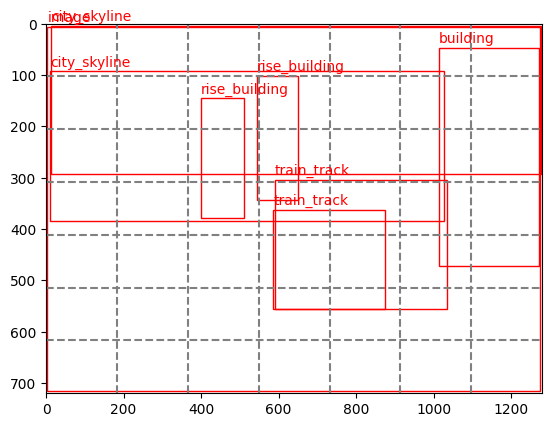

In [76]:

in_img = Image.open("/kaggle/input/aic-keyframesb1-l09-extra/L09_extra/V009/000436.jpg")
 
ram_tags, ram_bboxes, ram_label = inference(in_img, ram_model, grounding_dino_model, sam_model)
encoded = BBoxGrid(ram_bboxes, ram_label)
print("tag bbox: ",encoded.tag_encoded())
print("\n")
print("tag number: ",encoded.tag_numbered())
encoded.show()